# IMPORTS

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Concatenate, Add, Average, Reshape, Flatten

import re
import os
import copy
import requests
import zipfile
import random
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import sklearn.metrics as sk_metrics

In [2]:
# In order to use key_to_index attribute from the embedding model
! pip install gensim==4.1.2
! pip install matplotlib==3.5.0

import gensim.downloader as gloader
import matplotlib.pyplot as plt

In [3]:
EMBEDDING_SIZE = 100
BATCH_SIZE = 128
NUM_CLASSES = 2
EPOCHS = 3

In [4]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use. 
    """
    np.random.seed(seed)
    random.seed(seed)


fix_random(42)

# Check GPU:
!nvidia-smi


Thu Dec 23 09:23:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# PRE-PROCESSING

In [5]:
def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk:  # filter out keep-alive new chunks
                f.write(chunk)


def download_data(data_path):
    toy_data_path = os.path.join(data_path, 'fever_data.zip')
    toy_data_url_id = "1wArZhF9_SHW17WKNGeLmX-QTYw9Zscl1"
    toy_url = "https://docs.google.com/uc?export=download"

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(toy_data_path):
        print("Downloading FEVER data splits...")
        with requests.Session() as current_session:
            response = current_session.get(toy_url,
                                           params={'id': toy_data_url_id},
                                           stream=True)
        save_response_content(response, toy_data_path)
        print("Download completed!")

        print("Extracting dataset...")
        with zipfile.ZipFile(toy_data_path) as loaded_zip:
            loaded_zip.extractall(data_path)
        print("Extraction completed!")


def pre_process(dataset, filename, test_split=False):  # clean the dataset
    dataset.drop(dataset.columns[0], axis=1, inplace=True)  # remove first column of dataframe containing numbers
    dataset.drop(['ID'], axis=1, inplace=True)
    # remove numbers before each evidence
    dataset['Evidence'] = dataset['Evidence'].apply(lambda x: re.sub(r'^\d+\t', '', x))
    # remove everything after the period
    dataset['Evidence'] = dataset['Evidence'].apply(lambda x: re.sub(r' \..*', ' .', x))
    # remove round brackets and what they contain
    dataset['Evidence'] = dataset['Evidence'].apply(lambda x: re.sub(r'-LRB-.*-RRB-', '', x))
    # remove square brackets and what they contain
    dataset['Evidence'] = dataset['Evidence'].apply(lambda x: re.sub(r'-LSB-.*-RSB-', '', x))

    if not test_split:
        n_before = dataset.shape[0]
        # removes instances longer than a threshold on evidence
        dataset = dataset[dataset['Evidence'].str.split().str.len() <= 100]
        # remove all rows where there are single brackets in the evidence
        dataset = dataset[~dataset['Evidence'].str.contains('|'.join(['-LRB-', '-LSB-', '-RRB-', '-RSB-']))]
        n_after = dataset.shape[0]

        rem_elements = n_before - n_after
        print(f"Removed {rem_elements}\t ({100 * rem_elements / n_before:.2F}%)"
              f" elements because of inconsistency on {filename}")

    # removes punctuation and excessive spaces
    dataset = dataset.applymap(lambda x: re.sub(r'[^\w\s]', '', x))
    dataset = dataset.applymap(lambda x: re.sub(r' +', ' ', x))
    dataset = dataset.applymap(lambda x: re.sub(r'^ +', '', x))
    dataset = dataset.applymap(lambda x: x.lower())

    labels = {'supports': 1, 'refutes': 0}
    dataset = dataset.replace({'Label': labels})
    # removes rows with empty elements
    dataset = dataset[dataset['Evidence'] != '']
    dataset = dataset[dataset['Claim'] != '']
    dataset = dataset[dataset['Label'] != '']

    return dataset


#########################################

# IF YOU WANT TO USE DRIVE UNCOMMENT THE FOLLOWING

try:
    from google.colab import drive

    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    print("We're running Colab")
    # Mount the Google Drive at mount
    mount = '/content/gdrive'
    print("Colab: mounting Google drive on ", mount)
    drive.mount(mount)

    # Switch to the directory on the Google Drive that you want to use
    drive_root = mount + "/My Drive/NLP/Assignment2"

    # Create drive_root if it doesn't exist
    create_drive_root = True
    if create_drive_root:
        print("\nColab: making sure ", drive_root, " exists.")
        os.makedirs(drive_root, exist_ok=True)

    # Change to the directory
    print("\nColab: Changing directory to ", drive_root)
    % cd $drive_root
    print("Checking working directory:")
    % pwd

####################################################################

download_data('dataset')

if not os.path.exists("dataset_cleaned"):
    os.mkdir("dataset_cleaned")

if not len(os.listdir("dataset_cleaned")):
    for file in os.listdir("dataset"):
        if file != 'fever_data.zip':
            not_in_train = True if ("test" in file) or ("val" in file) else False
            dataset_cleaned = pre_process(pd.read_csv("dataset/" + file, sep=','),
                                          file, test_split=not_in_train)
            dataset_cleaned.to_csv(os.path.join("dataset_cleaned", file))


We're running Colab
Colab: mounting Google drive on  /content/gdrive
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).

Colab: making sure  /content/gdrive/My Drive/NLP/Assignment2  exists.

Colab: Changing directory to  /content/gdrive/My Drive/NLP/Assignment2
/content/gdrive/My Drive/NLP/Assignment2
Checking working directory:


# TOKENIZER

In [6]:
class Tokenizer(object):
    def __init__(self, dataset_sentences, embedding_dim, glove_dict, glove_matrix):
        self.embedding_matrix = None
        self.value_to_key = {}
        self.value_to_key_new = {}
        self.key_to_value = {}
        self.num_unique_words = 0
        self.dataset_sentences = dataset_sentences
        self.embedding_dim = embedding_dim
        self.glove_dict = glove_dict
        self.glove_matrix = glove_matrix
        self.unique_words = set()

    def get_val_to_key(self):
        return copy.deepcopy(self.value_to_key)

    def tokenize(self):
        self.value_to_key_new = {}
        unique_words = set()
        for sen in self.dataset_sentences:
            for w in sen.split():
                unique_words.add(w)  # get se of unique words
        new_unique = unique_words - self.unique_words
        for i, word in enumerate(new_unique):
            if self.embedding_matrix is not None:
                self.key_to_value[
                    i + len(self.embedding_matrix)] = word  # build two dictionaries for key value correspondence
                self.value_to_key[word] = i + len(self.embedding_matrix)
            else:
                self.key_to_value[i] = word  # build two dictionaries for key value correspondence
                self.value_to_key[word] = i
            self.value_to_key_new[word] = i

        self.num_unique_words = len(new_unique)
        self.unique_words = self.unique_words | new_unique  # union of unique words and new unique words

    def __build_embedding_matrix_glove(self):
        oov_words = []
        tmp_embedding_matrix = np.zeros((self.num_unique_words, self.embedding_dim))  #dtype=np.float32
        len_old_emb_matrix = len(self.embedding_matrix) if self.embedding_matrix is not None else 0
        for word, idx in tqdm(self.value_to_key_new.items()):
            try:
                embedding_vector = self.glove_matrix[self.glove_dict[word]]
                tmp_embedding_matrix[idx] = embedding_vector
            except (KeyError, TypeError):
                oov_words.append((word, idx + len_old_emb_matrix))

        if self.embedding_matrix is not None:
            self.embedding_matrix = np.vstack((self.embedding_matrix, tmp_embedding_matrix))

        else:
            self.embedding_matrix = copy.deepcopy(tmp_embedding_matrix)
        return oov_words

    def build_embedding_matrix(self):
        oov_words = self.__build_embedding_matrix_glove()
        for word, idx in oov_words:
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=self.embedding_dim)
            self.embedding_matrix[idx] = embedding_vector
        return copy.deepcopy(self.embedding_matrix)

# LOAD DATA

In [7]:
# Load Glove Embeddings from a pickle file or download if necessary
try:
    with open(f"glove-{EMBEDDING_SIZE}.pkl", 'rb') as f:
        emb_model = pickle.load(f)
except Exception:
    emb_model = gloader.load(f"glove-wiki-gigaword-{EMBEDDING_SIZE}")
    with open(f"glove-{EMBEDDING_SIZE}.pkl", 'wb') as f:
        pickle.dump(emb_model, f)
####################################################################

glove_dict = emb_model.key_to_index
glove_matrix = emb_model.vectors

# Load cleaned dataset
train = pd.read_csv("dataset_cleaned/train_pairs.csv")
val = pd.read_csv("dataset_cleaned/val_pairs.csv")
test = pd.read_csv("dataset_cleaned/test_pairs.csv")

# Compute vocabularies and tokenizer or load if already computed
try:
    with open("emb_mat.pkl", 'rb') as f:
        v4_matrix = pickle.load(f)
    with open("val_to_key.pkl", 'rb') as f:
        v4_val_to_key = pickle.load(f)
    with open(f"tokenizer.pkl", 'rb') as f:
        tokenizer = pickle.load(f)
except Exception as e:
    tokenizer = Tokenizer(train["Claim"] + ' ' + train["Evidence"], EMBEDDING_SIZE, glove_dict, glove_matrix)
    tokenizer.tokenize()
    v2_matrix = tokenizer.build_embedding_matrix()
    tokenizer.dataset_sentences = val["Claim"] + ' ' + val["Evidence"]
    tokenizer.tokenize()
    v3_matrix = tokenizer.build_embedding_matrix()
    tokenizer.dataset_sentences = test["Claim"] + ' ' + test["Evidence"]
    tokenizer.tokenize()
    v4_matrix = tokenizer.build_embedding_matrix()
    v4_val_to_key = tokenizer.get_val_to_key()
    with open(f"emb_mat.pkl", 'wb') as f:
        pickle.dump(v4_matrix, f)
    with open(f"val_to_key.pkl", 'wb') as f:
        pickle.dump(v4_val_to_key, f)
    with open(f"tokenizer.pkl", 'wb') as f:
        pickle.dump(tokenizer, f)

# Shifts tokens by 1 because of padding (to adapt to the network embedding layer)
v4_val_to_key.update((x, y + 1) for x, y in v4_val_to_key.items())

# Translation dictionary to retranslate from tokens to words
translate_tokens = {}
key_val_list_items = list(tokenizer.key_to_value.items())
for i, (token, value) in enumerate(key_val_list_items):
    if i > 0:
        translate_tokens[token] = key_val_list_items[i - 1][1]
    else:
        translate_tokens[i] = '<PAD>'

# Showing the train split:
train

,Unnamed: 0,Claim,Evidence,Label
0,0,chris hemsworth appeared in a perfect getaway,hemsworth has also appeared in the science fic...,1
1,1,roald dahl is a writer,roald dahl was a british novelist short story ...,1
2,2,roald dahl is a governor,roald dahl was a british novelist short story ...,0
3,3,ireland has relatively lowlying mountains,the island s geography comprises relatively lo...,1
4,4,ireland does not have relatively lowlying moun...,the island s geography comprises relatively lo...,0
...,...,...,...,...
121086,121735,april was the month anderson silva was born,anderson da silva is a brazilian mixed martial...,1
121087,121736,anderson silva is an american brazilian mixed ...,anderson da silva is a brazilian mixed martial...,0
121088,121737,anderson silva is incapable of being a brazili...,anderson da silva is a brazilian mixed martial...,0
121089,121738,anderson silva was born on the month of april ...,anderson da silva is a brazilian mixed martial...,1


# GENERATOR

In [8]:
def generator(dataset, value_to_key, adaptive_seq_batch=True):
    """
        Generates an infinite amount of balanced batches that are randomly chosen
        from the dataset but without the possibility of duplicates (wrt the batch)
    :param dataset: a split of the dataset
    :param value_to_key: dictionary to go from words to tokens
    :param adaptive_seq_batch: boolean to choose if the padding is given according to
                                the maximum length of a sentence in each batch.
    :return: yield a [np.array(X_claim), np.array(X_evid)], np.array(y) tuple
    """
    dataset_size = dataset.shape[0]
    dataset = dataset.to_numpy()[:, 1:]
    max_seq_global_claim = max([len(el[0].split()) for el in dataset])
    max_seq_global_evid = max([len(el[1].split()) for el in dataset])

    refutes = dataset[dataset[:, 2] == 0]
    supports = dataset[dataset[:, 2] == 1]

    while True:
        X_claim = []
        X_evid = []
        y = []

        # to have balanced data we choose from each class BATCH_SIZE//2 times
        rnd_choices_refutes = np.random.choice(np.arange(len(refutes)), replace=False, size=BATCH_SIZE // 2)
        rnd_choices_supports = np.random.choice(np.arange(len(supports)), replace=False, size=BATCH_SIZE // 2)

        batch = []
        for i in range(BATCH_SIZE // 2):
            batch.append(list(refutes[rnd_choices_refutes[i]]))
            batch.append(list(supports[rnd_choices_supports[i]]))

        random.shuffle(batch)

        max_seq_claim = max([len(el[0].split()) for el in batch])
        max_seq_evid = max([len(el[1].split()) for el in batch])

        for sample in batch:
            tokenized_claim = [value_to_key[word] for word in sample[0].split()]
            tokenized_evid = [value_to_key[word] for word in sample[1].split()]

            tmp_claim = [0] * ((max_seq_claim if adaptive_seq_batch else max_seq_global_claim) - len(
                tokenized_claim)) + tokenized_claim
            tmp_evid = [0] * ((max_seq_evid if adaptive_seq_batch else max_seq_global_evid) - len(
                tokenized_evid)) + tokenized_evid

            X_claim.append(tmp_claim)
            X_evid.append(tmp_evid)
            y.append(np.array([0, 1] if sample[2] == 1 else [1, 0]))  # one-hot

        yield [np.array(X_claim), np.array(X_evid)], np.array(y)


In [9]:
def generator_validation(dataset, value_to_key, max_len_claim=None, max_len_evid=None, adaptive_seq_batch=True,
                         prediction=False):
    """
        Generates an infinite amount of batches that are SEQUENTIALLY chosen
        from the dataset but without the possibility of duplicates (wrt the batch)
    :param dataset: a split of the dataset
    :param value_to_key: dictionary to go from words to tokens
    :param max_len_claim: maximum length of a sentence from train (claim)
    :param max_len_evid: maximum length of a sentence from train (evid)
    :param adaptive_seq_batch: boolean to choose if the padding is given according to
                                the maximum length of a sentence in each batch.
    :param prediction: boolean, used if we want to generate the whole test set
    :return: yield a [np.array(X_claim), np.array(X_evid)], np.array(y) tuple
    """
    dataset_size = dataset.shape[0]
    dataset = dataset.to_numpy()[:, 1:]
    np.random.shuffle(dataset)

    if prediction:
        batch_size = len(dataset)
    else:
        batch_size = BATCH_SIZE * 2

    def tokenize_and_pad(batch, X_claim, X_evid, y):
        max_seq_claim = max([len(el[0].split()) for el in batch])
        max_seq_evid = max([len(el[1].split()) for el in batch])

        for sample in batch:
            tokenized_claim = [value_to_key[word] for word in sample[0].split()]
            tokenized_evid = [value_to_key[word] for word in sample[1].split()]

            tmp_claim = [0] * ((max_seq_claim if adaptive_seq_batch else max_len_claim) - len(
                tokenized_claim)) + tokenized_claim
            tmp_evid = [0] * (
                    (max_seq_evid if adaptive_seq_batch else max_len_evid) - len(tokenized_evid)) + tokenized_evid

            # since lists are mutable we can change the outer meaning from here
            X_claim.append(tmp_claim)
            X_evid.append(tmp_evid)
            y.append(np.array([0, 1] if sample[2] == 1 else [1, 0]))  # one-hot

    i = 0

    while True:
        X_claim = []
        X_evid = []
        y = []

        if i > len(dataset):
            batch = []
            i -= batch_size
            remaining = batch_size - (len(dataset) - i)
            [batch.append(el) for el in dataset[i: len(dataset)]]
            [batch.append(el) for el in dataset[:remaining]]

            tokenize_and_pad(batch, X_claim, X_evid, y)
            yield [np.array(X_claim), np.array(X_evid)], np.array(y)
            i = 0

        else:
            batch = dataset[i: i + batch_size]
            tokenize_and_pad(batch, X_claim, X_evid, y)
            yield [np.array(X_claim), np.array(X_evid)], np.array(y)
            i += batch_size

## Check generator

In [10]:
[x_claims, x_evids], labels = next(generator(train, v4_val_to_key))
print(x_claims[0])
print(x_evids[0])
print(labels[0])

print(' '.join([translate_tokens[w] for w in x_claims[0]]))
print(' '.join([translate_tokens[w] for w in x_evids[0]]))

[    0     0     0     0     0     0     0     0     0     0     0 19127
  7837 22389  5765 28308  9696 13594]
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0  6493 13713 22389  5765 28308  9696
 13594 25666   652 16778  5728  3111  9321 22718 31499 19906 27249 13932
  5051 22143  9696 16778 10000   300 22430   548]
[0 1]
<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> slash left guns n roses in 1996
<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> after leaving guns n roses in 1996 he cofounded the supergroup velvet revolver which reestablished him as a mainstream performer in the mid to late 2000s


## Check unbalance in dataset

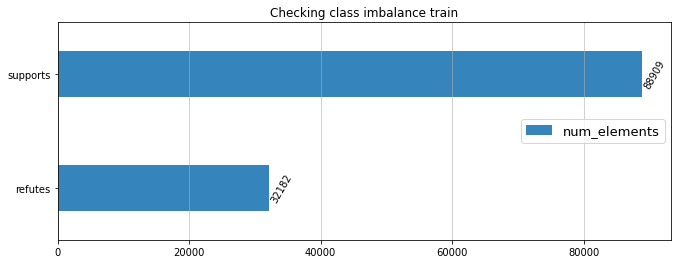

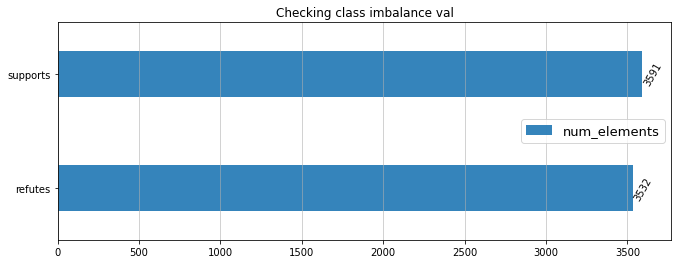

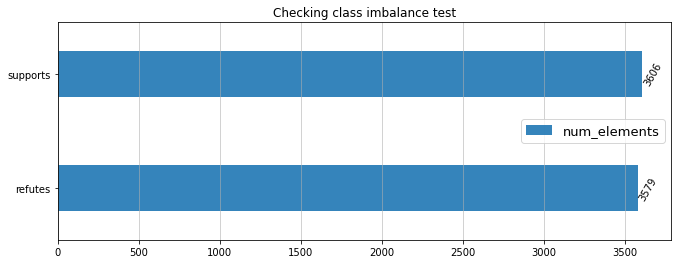

In [47]:
dataset_size = train.shape[0]
dataset_tmp = train.to_numpy()[:, 1:]

refutes = len(dataset_tmp[dataset_tmp[:, 2] == 0])
supports = len(dataset_tmp[dataset_tmp[:, 2] == 1])

lengths = [refutes, supports]

df = pd.DataFrame({'num_elements': lengths}, index=['refutes', 'supports'])
ax = df.plot.barh(figsize=(11, 4), fontsize=10, width=0.4, alpha=0.9)
ax.grid(axis='x', alpha=0.7)
plt.title(f"Checking class imbalance train")
ax.legend(loc='center right', fontsize=13)
for container in ax.containers:
    ax.bar_label(container, fontsize=10, rotation='60')




dataset_size = val.shape[0]
dataset_tmp = val.to_numpy()[:, 1:]

refutes = len(dataset_tmp[dataset_tmp[:, 2] == 0])
supports = len(dataset_tmp[dataset_tmp[:, 2] == 1])

lengths = [refutes, supports]

df = pd.DataFrame({'num_elements': lengths}, index=['refutes', 'supports'])
ax = df.plot.barh(figsize=(11, 4), fontsize=10, width=0.4, alpha=0.9)
ax.grid(axis='x', alpha=0.7)
plt.title(f"Checking class imbalance val")
ax.legend(loc='center right', fontsize=13)
for container in ax.containers:
    ax.bar_label(container, fontsize=10, rotation='60')



dataset_size = test.shape[0]
dataset_tmp = test.to_numpy()[:, 1:]

refutes = len(dataset_tmp[dataset_tmp[:, 2] == 0])
supports = len(dataset_tmp[dataset_tmp[:, 2] == 1])

lengths = [refutes, supports]

df = pd.DataFrame({'num_elements': lengths}, index=['refutes', 'supports'])
ax = df.plot.barh(figsize=(11, 4), fontsize=10, width=0.4, alpha=0.9)
ax.grid(axis='x', alpha=0.7)
plt.title(f"Checking class imbalance test")
ax.legend(loc='center right', fontsize=13)
for container in ax.containers:
    ax.bar_label(container, fontsize=10, rotation='60')

# MODEL

In [11]:
class Model(object):
    def __init__(self, compile_info, value_to_key, embedding_dim,
                 embedding_matrix, l2_reg, sentence_emb_type, merge_type, cosine,
                 max_seq_len_claim, max_seq_len_evid):
        """
        :param compile_info: compile information given to model.compile() function
        :param value_to_key: word to token dictionary
        :param embedding_dim: Embedding dimension
        :param embedding_matrix: Embedding matrix
        :param l2_reg: l2 regularization value passed to kernel_regularizer parameter
        :param sentence_emb_type: chosen from:
                    ['last_state',
                    'average_outputs',
                    'simple_mlp',
                    'mean_of_tokens']
        :param merge_type: chosen from:
                ['concatenation',
                'sum',
                'mean']
        :param cosine: boolean to choose if to use cosine similiarity
        :param max_seq_len_claim: if None the batches have to be padded dinamically,
                                otherwise batches have to be padded equally
        :param max_seq_len_evid: if None the batches have to be padded dinamically,
                                otherwise batches have to be padded equally
        """

        self.compile_info = compile_info
        self.value_to_key = value_to_key
        self.embedding_dim = embedding_dim
        self.embedding_matrix = embedding_matrix
        self.l2_reg = l2_reg
        self.sentence_emb_type = sentence_emb_type
        self.merge_type = merge_type
        self.cosine = cosine
        self.name = 'models/Model with: ' + sentence_emb_type + ' ' + merge_type
        self.max_seq_len_claim = max_seq_len_claim
        self.max_seq_len_evid = max_seq_len_evid

        if cosine:
            self.name += ' cosine'
        ##############
        # EMBEDDINGS #
        if max_seq_len_claim:
            input_claim = keras.layers.Input(shape=(max_seq_len_claim,))
            input_evid = keras.layers.Input(shape=(max_seq_len_evid,))
        else:
            input_claim = keras.layers.Input(shape=(None,))
            input_evid = keras.layers.Input(shape=(None,))
        emb_claim = layers.Embedding(input_dim=len(v4_val_to_key.keys()) + 1,
                                     output_dim=self.embedding_dim,
                                     input_length=self.max_seq_len_claim,
                                     mask_zero=True,
                                     weights=[self.embedding_matrix],
                                     trainable=False
                                     )(input_claim)
        emb_evid = layers.Embedding(input_dim=len(v4_val_to_key.keys()) + 1,
                                    output_dim=self.embedding_dim,
                                    input_length=self.max_seq_len_evid,
                                    mask_zero=True,
                                    weights=[self.embedding_matrix],
                                    trainable=False
                                    )(input_evid)
        ##############

        ###########################
        # SENTENCE EMBEDDING TYPE #
        if self.sentence_emb_type == 'last_state':
            lstm_claim, forward_h_claim, forward_c_claim = layers.LSTM(32,
                                                                       return_sequences=True,
                                                                       kernel_regularizer=l2(self.l2_reg),
                                                                       return_state=True)(emb_claim)
            lstm_evid, forward_h_evid, forward_c_evid = layers.LSTM(32,
                                                                    return_sequences=True,
                                                                    kernel_regularizer=l2(self.l2_reg),
                                                                    return_state=True)(emb_evid)
            merge1 = forward_h_claim
            merge2 = forward_h_evid

        elif self.sentence_emb_type == 'average':
            lstm_claim, forward_h_claim, forward_c_claim = layers.LSTM(32,
                                                                       return_sequences=True,
                                                                       kernel_regularizer=l2(self.l2_reg),
                                                                       return_state=True)(emb_claim)
            lstm_evid, forward_h_evid, forward_c_evid = layers.LSTM(32,
                                                                    return_sequences=True,
                                                                    kernel_regularizer=l2(self.l2_reg),
                                                                    return_state=True)(emb_evid)
            merge1 = Average()(lstm_claim)
            merge2 = Average()(lstm_evid)

        elif self.sentence_emb_type == 'simple_mlp':
            resh_claim = Flatten()(emb_claim)
            resh_evid = Flatten()(emb_evid)
            merge1 = layers.Dense(self.embedding_dim, activation='gelu', kernel_regularizer=l2(self.l2_reg))(resh_claim)
            merge2 = layers.Dense(self.embedding_dim, activation='gelu', kernel_regularizer=l2(self.l2_reg))(resh_evid)

        else:  # bag of vectors (mean of token embeddings)
            merge1 = tf.math.reduce_mean(emb_claim, 1)
            merge2 = tf.math.reduce_mean(emb_evid, 1)

        ###########################

        ###########
        # MERGING #
        if self.merge_type == 'concatenation':
            merge = Concatenate()([merge1, merge2])
        elif self.merge_type == 'sum':
            merge = Add()([merge1, merge2])
        else:  # mean
            merge = Average()([merge1, merge2])
        if self.cosine:
            n1 = tf.norm(merge1, axis=1, keepdims = 1)
            n2 = tf.norm(merge2, axis=1, keepdims = 1)
            dot_product = tf.keras.layers.Dot(axes = 1)([merge1, merge2])
            cosine = tf.math.divide(dot_product, tf.math.multiply(n1, n2))
            print(cosine)
            #cosine_sim = self.cosine_sim(merge1, merge2)
            #print(cosine_sim)
            merge = Concatenate()([merge, cosine])
            print(merge)
        ###########

        ##################
        # CLASSIFICATION #
        outputs = layers.Dense(2, activation="softmax")(merge)
        ##################

        model = keras.Model(inputs=[input_claim, input_evid], outputs=outputs)
        model.compile(**self.compile_info)
        model.summary()

        self.model = model

    def show_history(self, history: keras.callbacks.History):

        history_data = history.history
        print("Displaying the following history keys: ", history_data.keys())

        for key, value in history_data.items():
            if not key.startswith('val'):
                fig, ax = plt.subplots(1, 1)
                ax.set_title(key)
                ax.plot(value)
                if 'val_{}'.format(key) in history_data:
                    ax.plot(history_data['val_{}'.format(key)])
                else:
                    print("Couldn't find validation values for metric: ", key)

                ax.set_ylabel(key)
                ax.set_xlabel('epoch')
                ax.legend(['train', 'val'], loc='best')

        plt.show()

    def train_model(self,
                    train_generator,
                    val_generator,
                    steps_per_epoch,
                    verbose,
                    epochs,
                    validation_steps,
                    callbacks):

        print("Start training! \nParameters: {}".format(training_info))
        history = self.model.fit(train_generator,
                                 validation_data=val_generator,
                                 steps_per_epoch=steps_per_epoch,
                                 verbose=verbose,
                                 epochs=epochs,
                                 validation_steps=validation_steps,
                                 callbacks=callbacks)
        print("Training completed! Showing history...")

        self.show_history(history)

    def __str__(self):
        return self.name


In [12]:
# PARAMETERS FOR MODELS
if not os.path.exists("models"):
    os.mkdir("models")

max_seq_global_claim = max([len(el[0].split()) for el in train.to_numpy()[:, 1:]])
max_seq_global_evid = max([len(el[1].split()) for el in train.to_numpy()[:, 1:]])

compile_info = {
    'optimizer': keras.optimizers.Nadam(learning_rate=1e-3),
    'loss': 'categorical_crossentropy',
    'metrics': ['acc']
}

training_info = {
    'verbose': 1,
    'epochs': 3,
    'steps_per_epoch': train.shape[0] // BATCH_SIZE,
    'validation_steps': val.shape[0] // BATCH_SIZE * 2,  # doubled batch_size to go faster on validation
    'callbacks': [keras.callbacks.EarlyStopping(monitor='val_acc',
                                                patience=4,
                                                restore_best_weights=True)]
}

model_params = {
    'sentence_emb_type': 'mean_of_tokens',
    'merge_type': 'mean',
    'compile_info': compile_info,
    'value_to_key': v4_val_to_key,
    'embedding_dim': EMBEDDING_SIZE,
    'embedding_matrix': np.vstack((np.zeros((1, EMBEDDING_SIZE)), v4_matrix)),
    'l2_reg': 1e-4,
    'max_seq_len_claim': None,
    'max_seq_len_evid': None
}

prediction_info = {
    'batch_size': BATCH_SIZE,
    'verbose': 1
}

compile_info = {
    'optimizer': keras.optimizers.Nadam(learning_rate=1e-3),
    'loss': 'categorical_crossentropy',
    'metrics': ['acc']
}

sentence_emb_types = [
    'last_state',
    'average_outputs',
    'simple_mlp',
    'mean_of_tokens'
]

merge_types = [
    'concatenation',
    'sum',
    'mean'
]

cosines = [True, False]

In [ ]:
# Train and save 12 different models with different
# sentence embedding types and different merging types

# UNCOMMENT TO RUN AND SAVE


models = []
histories = []
for cosine in cosines:
    for sentence_emb_type in sentence_emb_types:
        for merge_type in merge_types:

            model_params['sentence_emb_type'] = sentence_emb_type
            model_params['merge_type'] = merge_type
            model_params['cosine'] = cosine

            if sentence_emb_type != 'simple_mlp': 
                model_params['max_seq_len_claim'] = None
                model_params['max_seq_len_evid'] = None
                model = Model(**model_params)
                # Usage of 'adaptive' to reduce masks in paddings
                history = model.train_model(generator(train, v4_val_to_key, adaptive_seq_batch=True),
                                generator_validation(val, v4_val_to_key, max_seq_global_claim, max_seq_global_evid, adaptive_seq_batch=True),
                                **training_info)

                
            else:
                model_params['max_seq_len_claim'] = max_seq_global_claim
                model_params['max_seq_len_evid'] = max_seq_global_evid
                model = Model(**model_params)
                history = model.train_model(generator(train, v4_val_to_key, adaptive_seq_batch=False),
                                generator_validation(val, v4_val_to_key, max_seq_global_claim, max_seq_global_evid, adaptive_seq_batch=False),
                                **training_info)


            models.append(model.model)
            histories.append(history)
            model.model.save(model.name)


# PERFORMANCE EVALUATION

In [27]:
def plot_histogram(scores, cosine = False, majority = True):
    '''
        plot histogram containing the scores (precision, recall, accuracy, f1)
        obtained with each model
    '''
    f1s = [round(s[0], 3) for s in scores]
    accs = [round(s[1], 3) for s in scores]
    precisions = [round(s[2], 3) for s in scores]
    recalls = [round(s[3], 3) for s in scores]

    if cosine: 
        names = [str(sentence_emb_type + '\n' + merge_type + ' cosine')
            for sentence_emb_type in sentence_emb_types
            for merge_type in merge_types]
    else:
        names = [str(sentence_emb_type + '\n' + merge_type)
            for sentence_emb_type in sentence_emb_types
            for merge_type in merge_types]

    df = pd.DataFrame({'f1': f1s, 'acc': accs,
                    'precision': precisions, 'recall': recalls}, index=names)

    ax = df.plot.bar(rot=0, figsize=(22, 12), fontsize=10, width=0.8, alpha=0.9)
    ax.grid(axis='y', alpha=0.7)
    if majority:
        plt.title(f"Scores with Majority Voting Evaluation {'with cosine' if cosine else ''} on test set")
    else: 
        plt.title(f"Scores with Multi Input Evaluation on test set")

    ax.legend(loc='upper right', fontsize=13)
    for container in ax.containers:
        ax.bar_label(container, fontsize=10, rotation='60')

In [28]:
lbl_token_to_class = {1: 'supports', 0: 'refutes'}

prediction_info = {
    'verbose': 1
}

def multi_input_evaluation(model, x, y_true):
    #start prediction
    print('Predicting on {} samples'.format(x[0].shape[0]))
    y_pred = model.predict(x, **prediction_info)

    # from one hot to label index
    y_pred_list = []
    y_true_list = []

    for y1, y2 in zip(y_pred, y_true):
        y_pred_list.append(np.argmax(y1))
        y_true_list.append(np.argmax(y2))

    f1 = sk_metrics.f1_score(y_true_list, y_pred_list)
    acc = sk_metrics.accuracy_score(y_true_list, y_pred_list)
    precision = sk_metrics.precision_score(y_true_list, y_pred_list)
    recall = sk_metrics.recall_score(y_true_list, y_pred_list)

    return f1, acc, precision, recall


In [30]:
model_names = [str('models/Model with: ' + sentence_emb_type + ' ' + merge_type)
               for sentence_emb_type in sentence_emb_types
               for merge_type in merge_types]

model_names_cosine = [str('models/Model with: ' + sentence_emb_type + ' ' + merge_type + ' cosine')
               for sentence_emb_type in sentence_emb_types
               for merge_type in merge_types]


# UNCOMMENT TO LOAD IF ALREADY TRAINED
# models = [keras.models.load_model(m) for m in model_names]

######################################################################


max_seq_global_claim = max([len(el[0].split()) for el in train.to_numpy()[:, 1:]])
max_seq_global_evid = max([len(el[1].split()) for el in train.to_numpy()[:, 1:]])

x, y = next(generator_validation(test,
                                 v4_val_to_key,
                                 max_len_claim=max_seq_global_claim,
                                 max_len_evid=max_seq_global_evid,
                                 adaptive_seq_batch=False,
                                 prediction=True))

'''
    evaluate models multi input
'''

models = []
scores = []
for m_name in model_names:
    print("LOADING: ", m_name)
    models.append(keras.models.load_model(m_name))

    print("EVALUATING: ", m_name)
    scores.append(multi_input_evaluation(models[-1], x, y))
    print("SCORES: ", scores[-1])
    print()

LOADING:  models/Model with: last_state concatenation
EVALUATING:  models/Model with: last_state concatenation
Predicting on 7185 samples
225/225 [==============================] - 13s 45ms/step
SCORES:  (0.7409695179266819, 0.7315240083507307, 0.7183025253840146, 0.7651136993899057)

LOADING:  models/Model with: last_state sum
EVALUATING:  models/Model with: last_state sum
Predicting on 7185 samples
225/225 [==============================] - 13s 46ms/step
SCORES:  (0.7330204307012701, 0.7308281141266527, 0.7297965915338098, 0.7362728785357737)

LOADING:  models/Model with: last_state mean
EVALUATING:  models/Model with: last_state mean
Predicting on 7185 samples
225/225 [==============================] - 13s 45ms/step
SCORES:  (0.7305898491083677, 0.7266527487821851, 0.7228555917480999, 0.7384914032168608)

LOADING:  models/Model with: average_outputs concatenation
EVALUATING:  models/Model with: average_outputs concatenation
Predicting on 7185 samples
225/225 [=======================

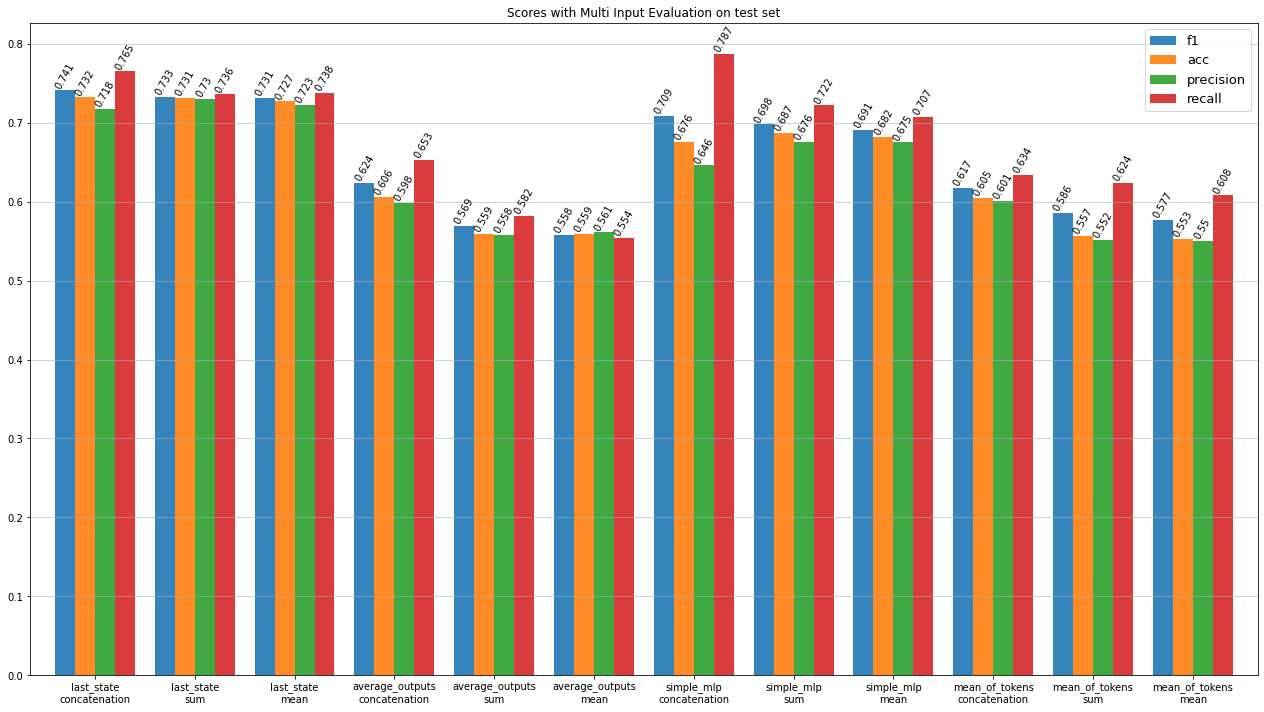

In [31]:
plot_histogram(scores, cosine= False, majority = False)

In [18]:
def majority_voting(model, x, y_true):
    #start prediction
    print('Predicting on {} samples'.format(x[0].shape[0]))
    y_pred = model.predict(x, **prediction_info)

    # from one hot to label index
    y_pred_list = []
    y_true_list = []

    for y1, y2 in zip(y_pred, y_true):
        y_pred_list.append(np.argmax(y1))
        y_true_list.append(np.argmax(y2))

    maj_vot = []
    df = pd.DataFrame(pd.DataFrame(x[:][0]).apply(lambda x: ' '.join(x.astype(str)), axis=1))
    df['y_true'] = y_true_list
    df['y_pred'] = y_pred_list
    df = df.rename(columns={0: 'Claim'})
    voting_df = df.groupby('Claim', as_index=False).mean()
    voting_df['y_pred'] = voting_df['y_pred'].apply(lambda x: random.randint(0, 1) if x == 0.5 else round(x))

    y_pred_list = voting_df['y_pred'].astype('int32').tolist()
    y_true_list = voting_df['y_true'].astype('int32').tolist()

    f1 = sk_metrics.f1_score(y_true_list, y_pred_list)
    acc = sk_metrics.accuracy_score(y_true_list, y_pred_list)
    precision = sk_metrics.precision_score(y_true_list, y_pred_list)
    recall = sk_metrics.recall_score(y_true_list, y_pred_list)

    return f1, acc, precision, recall

In [35]:
x, y = next(generator_validation(test,
                                 v4_val_to_key,
                                 max_len_claim=max_seq_global_claim,
                                 max_len_evid=max_seq_global_evid,
                                 adaptive_seq_batch=False,
                                 prediction=True))

'''
    evaluate models majority voting
'''

models = []
scores = []
for m_name in model_names:
    print("LOADING: ", m_name)
    models.append(keras.models.load_model(m_name))

    print("EVALUATING: ", m_name)
    scores.append(majority_voting(models[-1], x, y))
    print("SCORES: ", scores[-1])

LOADING:  models/Model with: last_state concatenation
EVALUATING:  models/Model with: last_state concatenation
Predicting on 7185 samples
225/225 [==============================] - 13s 46ms/step
SCORES:  (0.739401126593537, 0.7304507819687213, 0.7179044329303397, 0.7622249388753056)
LOADING:  models/Model with: last_state sum
EVALUATING:  models/Model with: last_state sum
Predicting on 7185 samples
225/225 [==============================] - 14s 49ms/step
SCORES:  (0.7293794785790516, 0.7278442195645507, 0.7277152418618801, 0.7310513447432763)
LOADING:  models/Model with: last_state mean
EVALUATING:  models/Model with: last_state mean
Predicting on 7185 samples
225/225 [==============================] - 14s 45ms/step
SCORES:  (0.727107337780473, 0.7240110395584176, 0.7214199759326113, 0.7328850855745721)
LOADING:  models/Model with: average_outputs concatenation
EVALUATING:  models/Model with: average_outputs concatenation
Predicting on 7185 samples
225/225 [============================

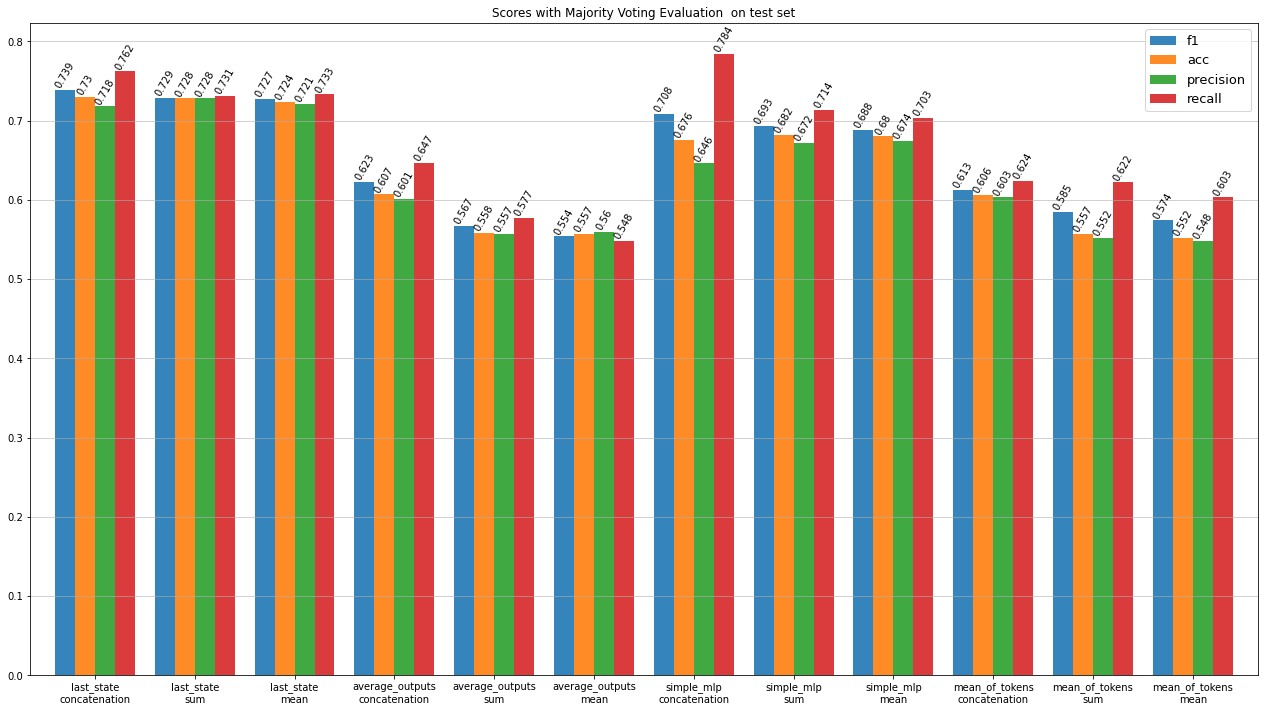

In [36]:
plot_histogram(scores, cosine= False, majority = True)

LOADING:  models/Model with: last_state concatenation cosine
EVALUATING:  models/Model with: last_state concatenation cosine
Predicting on 7185 samples
225/225 [==============================] - 30s 81ms/step
SCORES:  (0.7199508146326468, 0.7206378411530205, 0.7241805813234384, 0.7157701711491442)

LOADING:  models/Model with: last_state sum cosine
EVALUATING:  models/Model with: last_state sum cosine
Predicting on 7185 samples
225/225 [==============================] - 13s 47ms/step
SCORES:  (0.7473319473319473, 0.7204845139527752, 0.6837433426325134, 0.823960880195599)

LOADING:  models/Model with: last_state mean cosine
EVALUATING:  models/Model with: last_state mean cosine
Predicting on 7185 samples
225/225 [==============================] - 14s 47ms/step
SCORES:  (0.7501795719005889, 0.7333639987733824, 0.7077798861480076, 0.7979828850855746)

LOADING:  models/Model with: average_outputs concatenation cosine
EVALUATING:  models/Model with: average_outputs concatenation cosine
Pred

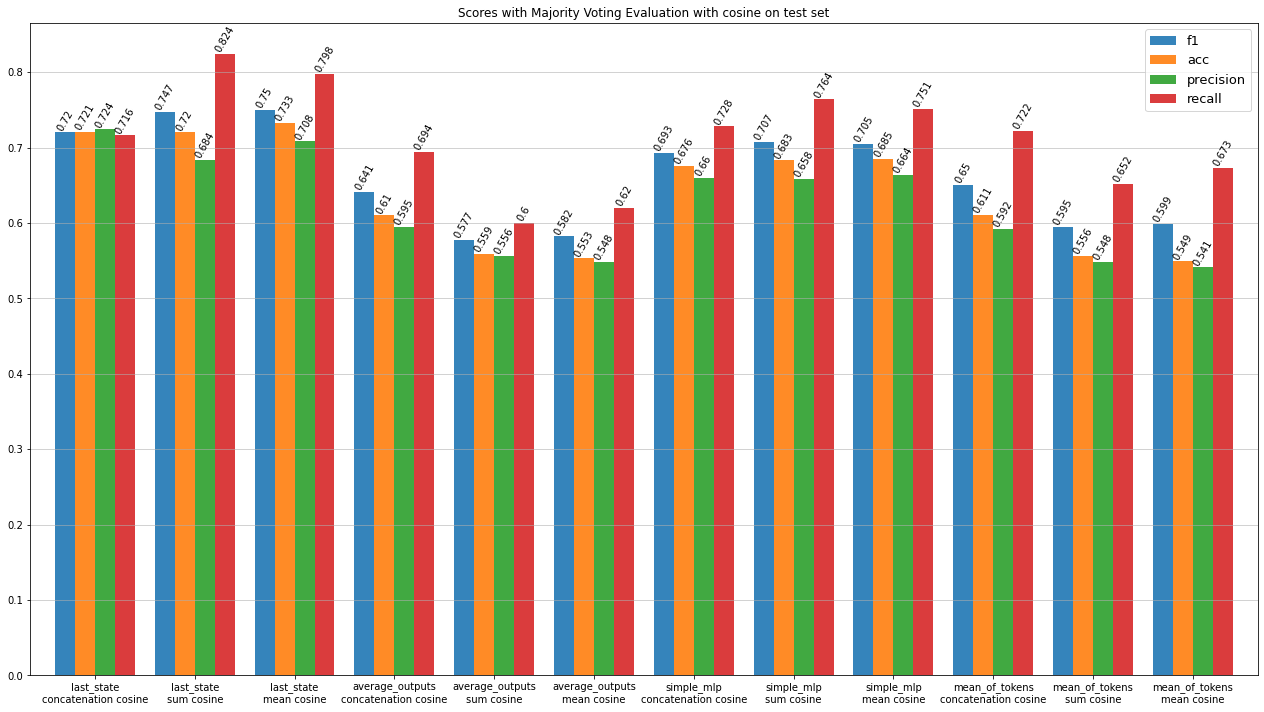

In [34]:
'''
    show performances of models merging with cosine similarity (majority voting)
'''
models = []
scores = []
for m_name in model_names_cosine:
    print("LOADING: ", m_name)
    models.append(keras.models.load_model(m_name))

    print("EVALUATING: ", m_name)
    scores.append(majority_voting(models[-1], x, y))
    print("SCORES: ", scores[-1])
    print()

plot_histogram(scores, cosine =True, majority = True)

# EXTRA: MODEL WITH ATTENTION

We tried to use a multi head attention layer to see how it performs.

In [22]:
!pip install keras-pos-embd
from keras_pos_embd import PositionEmbedding


  Created wheel for keras-pos-embd: filename=keras_pos_embd-0.12.0-py3-none-any.whl size=7469 sha256=9f4df5eb3c0e2be8c5375651836d2f15fbef6f5ecb0d26e7304731b0d64420ce
  Stored in directory: /root/.cache/pip/wheels/77/99/fd/dd98f4876c3ebbef7aab0dbfbd37bca41d7db37d3a28b2cb09
Successfully built keras-pos-embd


In [23]:
class ModelAttentioned(object):
    def __init__(self, compile_info, value_to_key, embedding_dim,
                 embedding_matrix, l2_reg, sentence_emb_type, merge_type,
                 max_seq_len_claim, max_seq_len_evid):

        self.compile_info = compile_info
        self.value_to_key = value_to_key
        self.embedding_dim = embedding_dim
        self.embedding_matrix = embedding_matrix
        self.l2_reg = l2_reg
        self.sentence_emb_type = sentence_emb_type
        self.merge_type = merge_type
        self.name = 'models/Model with: ' + sentence_emb_type + ' ' + merge_type

        input_claim = keras.layers.Input(shape=(max_seq_len_claim,))
        input_evid = keras.layers.Input(shape=(max_seq_len_evid,))

        emb_claim = layers.Embedding(input_dim=len(v4_val_to_key.keys()) + 1,
                                     output_dim=self.embedding_dim,
                                     mask_zero=True,
                                     input_length=max_seq_len_claim,
                                     weights=[self.embedding_matrix],
                                     trainable=False
                                     )(input_claim)
        emb_evid = layers.Embedding(input_dim=len(v4_val_to_key.keys()) + 1,
                                    output_dim=self.embedding_dim,
                                    mask_zero=True,
                                    input_length=max_seq_len_evid,
                                    weights=[self.embedding_matrix],
                                    trainable=False
                                    )(input_evid)

        pos_claim = PositionEmbedding(input_dim=90, output_dim=self.embedding_dim,
                                      mode=PositionEmbedding.MODE_ADD)(emb_claim)
        pos_evid = PositionEmbedding(input_dim=90, output_dim=self.embedding_dim,
                                     mode=PositionEmbedding.MODE_ADD)(emb_evid)

        query_value_attention_seq = tf.keras.layers.MultiHeadAttention(num_heads=2,
                                                                       key_dim=self.embedding_dim,
                                                                       kernel_regularizer=l2(1e-5),
                                                                       dropout=0.1)(pos_claim, pos_evid)

        flatten = Flatten()(query_value_attention_seq)
        dense = layers.Dense(128, activation='gelu', kernel_regularizer=l2(1e-5))(flatten)
        outputs = layers.Dense(2, activation="softmax")(dense)

        model = keras.Model(inputs=[input_claim, input_evid], outputs=outputs)
        model.compile(**self.compile_info)
        model.summary()

        self.model = model

    def show_history(self, history: keras.callbacks.History):

        history_data = history.history
        print("Displaying the following history keys: ", history_data.keys())

        for key, value in history_data.items():
            if not key.startswith('val'):
                fig, ax = plt.subplots(1, 1)
                ax.set_title(key)
                ax.plot(value)
                if 'val_{}'.format(key) in history_data:
                    ax.plot(history_data['val_{}'.format(key)])
                else:
                    print("Couldn't find validation values for metric: ", key)

                ax.set_ylabel(key)
                ax.set_xlabel('epoch')
                ax.legend(['train', 'val'], loc='best')

        plt.show()

    def train_model(self,
                    train_generator,
                    val_generator,
                    steps_per_epoch,
                    verbose,
                    epochs,
                    validation_steps,
                    callbacks):

        print("Start training! \nParameters: {}".format(training_info))
        history = self.model.fit(train_generator,
                                 validation_data=val_generator,
                                 steps_per_epoch=steps_per_epoch,
                                 verbose=verbose,
                                 epochs=epochs,
                                 validation_steps=validation_steps,
                                 callbacks=callbacks)
        print("Training completed! Showing history...")

        self.show_history(history)

    def __str__(self):
        return self.name

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 65)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 90)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 65, 100)      3529500     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 90, 100)      3529500     ['input_2[0][0]']                
                                                                                              

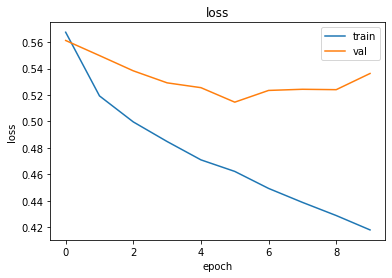

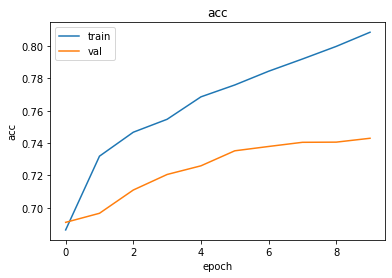

In [24]:
compile_info = {
    'optimizer': keras.optimizers.Nadam(learning_rate=1e-3),
    'loss': 'categorical_crossentropy',
    'metrics': ['acc']
}

training_info = {
    'verbose': 1,
    'epochs': 10,
    'steps_per_epoch': train.shape[0] // BATCH_SIZE,
    'validation_steps': val.shape[0] // BATCH_SIZE * 2,  # doubled batch_size to go faster on validation
    'callbacks': [keras.callbacks.EarlyStopping(monitor='val_acc',
                                                patience=4,
                                                restore_best_weights=True)]
}

max_seq_global_claim = max([len(el[0].split()) for el in train.to_numpy()[:, 1:]])
max_seq_global_evid = max([len(el[1].split()) for el in train.to_numpy()[:, 1:]])

model_params = {
    'sentence_emb_type': 'attention',
    'merge_type': '',
    'compile_info': compile_info,
    'value_to_key': v4_val_to_key,
    'embedding_dim': EMBEDDING_SIZE,
    'embedding_matrix': np.vstack((np.zeros((1, EMBEDDING_SIZE)), v4_matrix)),
    'l2_reg': 1e-4,
    'max_seq_len_claim': max_seq_global_claim,
    'max_seq_len_evid': max_seq_global_evid
}

prediction_info = {
    'batch_size': BATCH_SIZE,
    'verbose': 1
}
model = ModelAttentioned(**model_params)

history = model.train_model(generator(train, v4_val_to_key, adaptive_seq_batch=False),
                            generator_validation(val, v4_val_to_key, adaptive_seq_batch=False,
                                                 max_len_claim=max_seq_global_claim,
                                                 max_len_evid=max_seq_global_evid),
                            **training_info)



In [25]:
x, y = next(generator_validation(test,
                                 v4_val_to_key,
                                 max_len_claim=max_seq_global_claim,
                                 max_len_evid=max_seq_global_evid,
                                 adaptive_seq_batch=False,
                                 prediction=True))

majority_voting_score_attention = majority_voting(model.model, x, y)
print("Majority voting score")
print("f1 score: ", majority_voting_score_attention[0])
print("accuracy : ", majority_voting_score_attention[1])
print("precision: ", majority_voting_score_attention[2])
print("recall: ", majority_voting_score_attention[3])

Predicting on 7185 samples
57/57 [==============================] - 1s 12ms/step
Majority voting score
f1 score:  0.748970024151158
accuracy :  0.7290708371665133
precision:  0.6997610830899921
recall:  0.8056234718826406


In [26]:
multi_input_score_attention = multi_input_evaluation(model.model, x, y)
print("Multi Input score")
print("f1 score: ", multi_input_score_attention[0])
print("accuracy : ", multi_input_score_attention[1])
print("precision: ", multi_input_score_attention[2])
print("recall: ", multi_input_score_attention[3])

Predicting on 7185 samples
57/57 [==============================] - 1s 11ms/step
Multi Input score
f1 score:  0.7509331960355258
accuracy :  0.7306889352818372
precision:  0.7006966130194571
recall:  0.8089295618413754


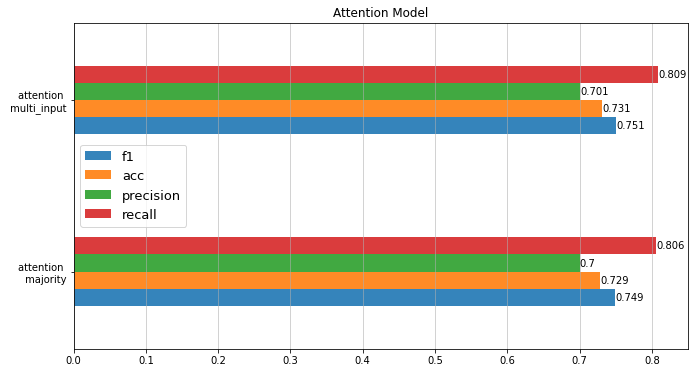

In [55]:
df = pd.DataFrame({'f1': [round(majority_voting_score_attention[0], 3), round(multi_input_score_attention[0], 3)], 
                   'acc':  [round(majority_voting_score_attention[1], 3), round(multi_input_score_attention[1], 3)],
                   'precision': [round(majority_voting_score_attention[2], 3), round(multi_input_score_attention[2], 3)], 
                   'recall': [round(majority_voting_score_attention[3], 3), round(multi_input_score_attention[3], 3)]}, 
                  index=['attention \n majority', 'attention \n multi_input'])

ax = df.plot.barh(figsize=(11, 6), fontsize=10, width=0.4, alpha=0.9)
ax.grid(axis='x', alpha=0.7)
plt.title(f"Attention Model")
ax.legend(loc='center left', fontsize=13)
for container in ax.containers:
    ax.bar_label(container, fontsize=10, rotation='0')